In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model

In [ ]:
from IPython.display import SVG
from urllib.request import urlretrieve
import zipfile
import collections

In [ ]:
# Download MovieLens data.
print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [141]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995


In [146]:
movies.to_csv('/content/drive/MyDrive/Portfolio/Github-Recommender-System-master/movies.csv')

In [ ]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [ ]:
movielens.drop(columns=['video_release_date', 'imdb_url'],axis=1,inplace=True)
mvlens = movielens.copy()

In [145]:
# movielens.to_csv('/content/drive/MyDrive/Portfolio/Github-Recommender-System-master/movielens.csv')

In [ ]:
movielens['age'].describe()

count    100000.000000
mean         32.969850
std          11.562623
min           7.000000
25%          24.000000
50%          30.000000
75%          40.000000
max          73.000000
Name: age, dtype: float64

In [ ]:
bins = [0,12,18,24,30,40,100]
labels = ['kid','teen','adolescent','young_adult','adult','senior']
movielens['age_group'] = pd.cut(movielens['age'], bins=bins, labels=labels, right=False)

In [ ]:
movielens['age_group'].value_counts()

senior         26545
young_adult    25764
adult          25696
adolescent     19504
teen            2390
kid              101
Name: age_group, dtype: int64

In [ ]:
movielens.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'title',
       'release_date', 'genre_unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'year', 'age', 'sex', 'occupation',
       'zip_code', 'age_group'],
      dtype='object')

In [ ]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
MultiColumnLabelEncoder(columns = ['age_group','title','sex','occupation']).fit_transform(movielens)

,user_id,movie_id,rating,unix_timestamp,title,release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code,age_group
0,195,241,3.0,881250949,825,24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,49,1,20,55105,3
1,195,256,2.0,881251577,964,04-Jul-1997,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,49,1,20,55105,3
2,195,110,4.0,881251793,1537,26-Apr-1996,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,49,1,20,55105,3
3,195,24,4.0,881251955,178,08-Mar-1996,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,49,1,20,55105,3
4,195,381,4.0,881251843,24,01-Jan-1994,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,49,1,20,55105,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,872,312,5.0,891392177,1500,01-Jan-1997,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1997,48,0,0,33763,3
99996,872,325,4.0,891392656,577,01-Jan-1997,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1997,48,0,0,33763,3
99997,872,347,3.0,891392577,407,30-Jan-1998,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1998,48,0,0,33763,3
99998,872,357,2.0,891392698,1369,01-Aug-1997,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1997,48,0,0,33763,3


In [ ]:
mvseg = movielens[['user_id', 'movie_id', 'rating', 'title',
       'genre_unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'sex', 'occupation','zip_code','age_group']]

In [ ]:
mvseg['zip_code'] = mvseg.zip_code.astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
mvseg = MultiColumnLabelEncoder(columns = ['age_group','title','zip_code','sex','occupation']).fit_transform(mvseg)

In [ ]:
mvseg.head()

,user_id,movie_id,rating,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,sex,occupation,zip_code,age_group
0,195,241,3.0,825,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
1,195,256,2.0,964,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,20,415,3
2,195,110,4.0,1537,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,20,415,3
3,195,24,4.0,178,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
4,195,381,4.0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,20,415,3


In [ ]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
scaler = StandardScaler()
mvseg_scaled = scaler.fit_transform(mvseg)

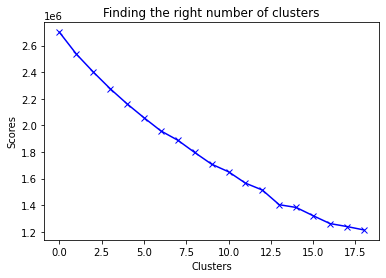

In [ ]:
scores_1 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(mvseg_scaled)
  scores_1.append(kmeans.inertia_) 

plt.plot(scores_1, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

In [ ]:
# mvseg[mvseg.eq('E2A4H').any(1)]
mvseg.drop(columns=['title'],axis=1, inplace=True)

In [ ]:
# mvseg['rating'] = mvseg['rating'].map({5:1,4:.5,3:0,2:-.5,1:-1})

In [ ]:
mvseg.head()

,user_id,movie_id,rating,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,sex,occupation,zip_code,age_group
0,195,241,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
1,195,256,2.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,20,415,3
2,195,110,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,20,415,3
3,195,24,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
4,195,381,4.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,20,415,3


In [ ]:
unique_movies = mvseg['user_id'].nunique()

In [ ]:
user_autoenc = mvseg.drop('movie_id',axis=1)

In [ ]:
movie_autoenc = mvseg.drop('user_id',axis=1)

In [ ]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD

encoding_dim = 7

input_df = Input(shape=(26,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution 

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu')(x)
x = Dense(500, activation='relu')(x)
x = Dense(2000, activation='relu')(x)

encoded = Dense(10, activation='relu')(x)

x = Dense(2000, activation='relu')(encoded)
x = Dense(500, activation='relu')(x)

decoded = Dense(26)(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')


In [ ]:
autoencoder.fit(mvseg, mvseg, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25
782/782 [==============================] - 43s 54ms/step - loss: 398.8864
Epoch 2/25
782/782 [==============================] - 42s 54ms/step - loss: 10.9707
Epoch 3/25
782/782 [==============================] - 42s 53ms/step - loss: 10.9578
Epoch 4/25
782/782 [==============================] - 42s 53ms/step - loss: 11.3770
Epoch 5/25
782/782 [==============================] - 42s 54ms/step - loss: 9.2260
Epoch 6/25
782/782 [==============================] - 42s 54ms/step - loss: 8.7873
Epoch 7/25
782/782 [==============================] - 42s 54ms/step - loss: 9.7959
Epoch 8/25
782/782 [==============================] - 42s 53ms/step - loss: 7.1628
Epoch 9/25
782/782 [==============================] - 42s 54ms/step - loss: 8.7196
Epoch 10/25
782/782 [==============================] - 42s 54ms/step - loss: 6.4489
Epoch 11/25
782/782 [==============================] - 42s 53ms/step - loss: 11.4845
Epoch 12/25
782/782 [==============================] - 42s 53ms/step - loss: 4.

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [ ]:
pred = encoder.predict(mvseg)

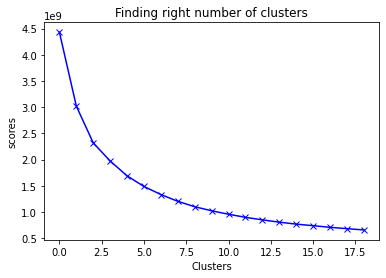

In [ ]:
scores_2 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(pred)
  scores_2.append(kmeans.inertia_)

plt.plot(scores_2, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [ ]:
kmeans = KMeans(7)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(mvseg)

In [ ]:
df_cluster_dr = pd.concat([mvseg, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,user_id,movie_id,rating,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,sex,occupation,zip_code,age_group,cluster
0,195,241,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3,0
1,195,256,2.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,20,415,3,0
2,195,110,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,20,415,3,3
3,195,24,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3,3
4,195,381,4.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,20,415,3,0


In [ ]:
mvseg.head()

,user_id,movie_id,rating,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,sex,occupation,zip_code,age_group
0,195,241,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
1,195,256,2.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,20,415,3
2,195,110,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,20,415,3
3,195,24,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
4,195,381,4.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,20,415,3


In [ ]:
mvseg['rating'].value_counts()

4.0    34174
3.0    27145
5.0    21201
2.0    11370
1.0     6110
Name: rating, dtype: int64

In [ ]:
# mvseg['rating'] = mvseg['rating'].map({5:1,4:.5,3:0,2:-.5,1:-1})

In [ ]:
# mvseg['rating'] = mvseg['rating'].map({1:5,.5:4,0:3,-.5:2,-1:1})

In [ ]:
mvseg

,user_id,movie_id,rating,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,sex,occupation,zip_code,age_group
0,195,241,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
1,195,256,2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,20,415,3
2,195,110,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,20,415,3
3,195,24,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
4,195,381,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,20,415,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,872,312,5,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,287,3
99996,872,325,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,287,3
99997,872,347,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,287,3
99998,872,357,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,287,3


In [ ]:
# movielens = movielens[['user_id', 'movie_id', 'rating', 
#        'release_date', 'genre_unknown', 'Action', 'Adventure', 'Animation',
#        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
#        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
#        'Thriller', 'War', 'Western', 'age', 'sex', 'occupation']]

movielens = mvseg.copy()

In [ ]:
movielens.head()

,user_id,movie_id,rating,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,sex,occupation,zip_code,age_group
0,195,241,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
1,195,256,2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,20,415,3
2,195,110,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,20,415,3
3,195,24,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,415,3
4,195,381,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,20,415,3


In [ ]:
min_rating = min(movielens["rating"])
max_rating = max(movielens["rating"])

In [ ]:
train, test = train_test_split(movielens, test_size=0.1)

In [ ]:
ROW_COUNT = train.shape[0]

In [ ]:
EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()

In [ ]:
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

In [ ]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [ ]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:

callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/50
900/900 [==============================] - 3s 3ms/step - loss: 1.0830 - val_loss: 0.9292
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9553 - val_loss: 0.9208
Epoch 3/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9202 - val_loss: 0.8448
Epoch 4/50
900/900 [==============================] - 2s 2ms/step - loss: 0.7846 - val_loss: 0.7829
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 0.7164 - val_loss: 0.7745
Epoch 6/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6815 - val_loss: 0.7693
Epoch 7/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6634 - val_loss: 0.7679
Epoch 8/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6499 - val_loss: 0.7685
Epoch 9/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6386 - val_loss: 0.7681
Epoch 10/50
900/900 [==============================] - 2s 2ms/step - loss: 0.6300 - val_loss: 0.7716

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 10)        16820       movie_id[0][0]                   
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 10)        9430        user_id[0][0]                    
___________________________________________________________________________________________

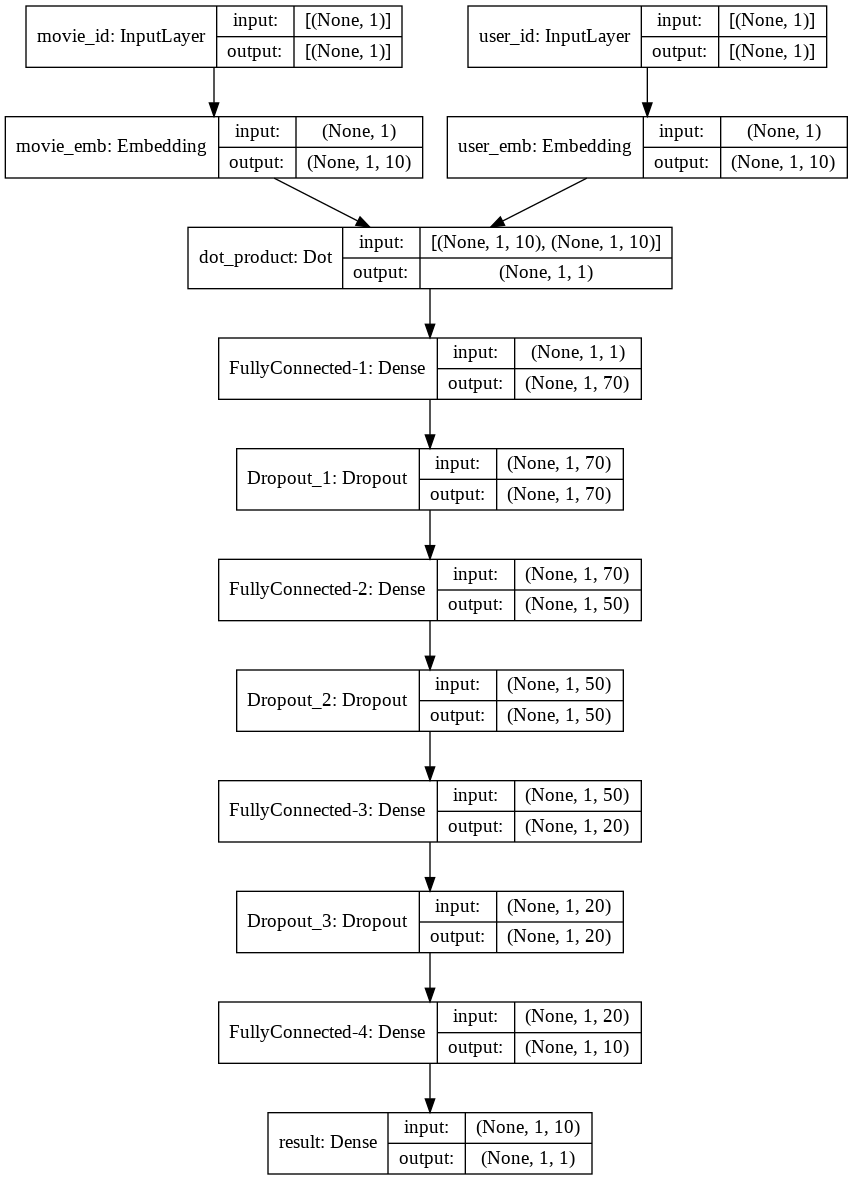

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

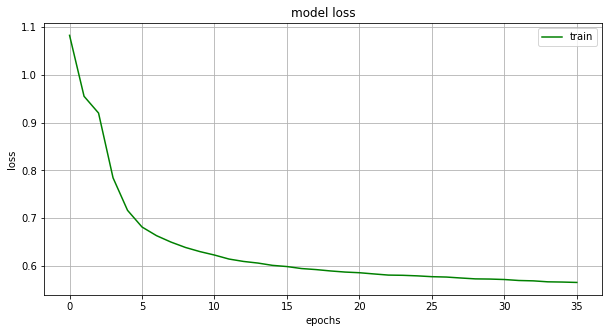

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:

TEST_USER_ID = 20
TEST_MOVIE_ID = 123

In [ ]:
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

In [ ]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
def tsne_plot(model, MOVIE_EMBEDDING_LIST, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

In [ ]:
tsne_plot(model, MOVIE_EMBEDDING_LIST)

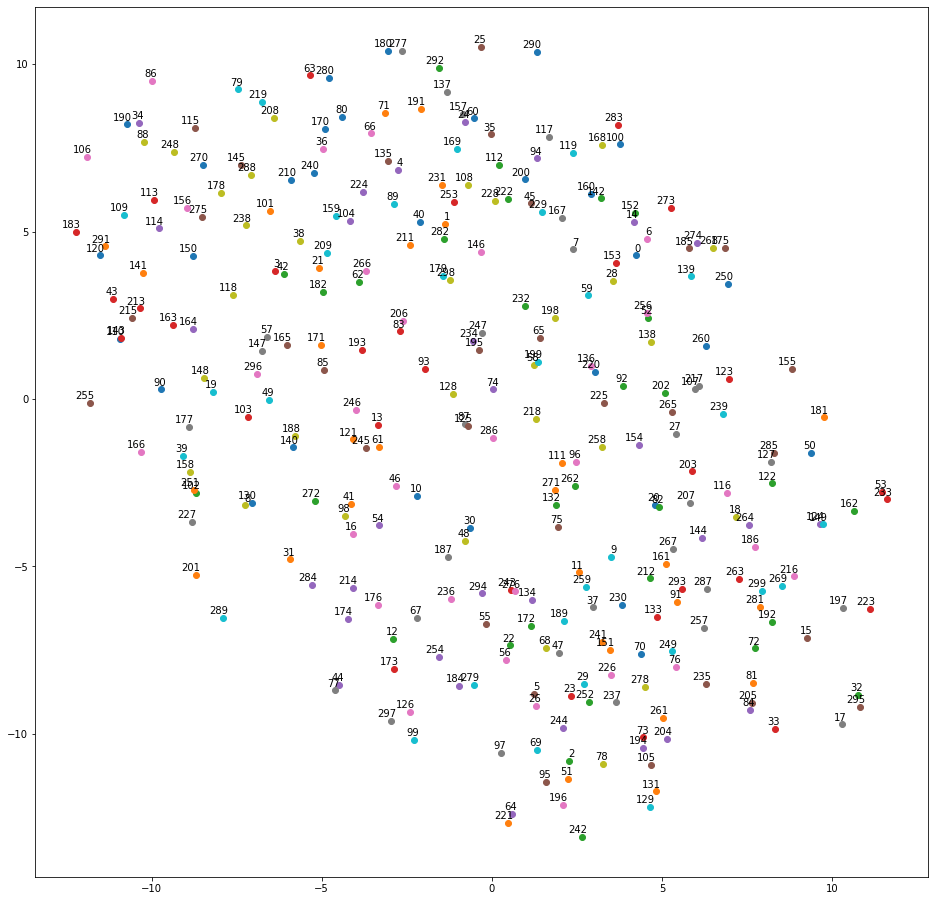

In [ ]:
tsne_plot(model, MOVIE_EMBEDDING_LIST, 300)

In [ ]:
np.average(movielens.loc[movielens['movie_id'] == 53, 'rating'], axis=0)

3.2403846153846154

In [ ]:
knn_train_label = UNIQUE_MOVIE_IDS

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [ ]:

def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    recs = df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])
    return recs[['movie_id','title']]

In [ ]:
TEST_USER_ID

20

In [ ]:
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]

In [ ]:
rec_movies = recommend_movies(user_embedding)
rec_movies

,movie_id,title
0,301,L.A. Confidential (1997)
1,404,Mission: Impossible (1996)
2,487,Sunset Blvd. (1950)
3,947,Booty Call (1997)
4,1119,I'm Not Rappaport (1996)
5,1308,"Very Natural Thing, A (1974)"
6,871,Love Jones (1997)
7,1489,Fausto (1993)
8,1547,The Courtyard (1995)
9,951,Blue in the Face (1995)


In [ ]:
rec_mvlist = list(rec_movies['movie_id'])

In [ ]:
user = mvlens.loc[mvlens['user_id'] == 20]

In [ ]:
user.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'title',
       'release_date', 'genre_unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'year', 'age', 'sex', 'occupation',
       'zip_code'],
      dtype='object')

In [ ]:
user[['genre_unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western']].sum(axis=0)

genre_unknown     0
Action           39
Adventure        16
Animation         9
Children         12
Comedy           32
Crime            15
Documentary       1
Drama            47
Fantasy           2
Film-Noir         2
Horror           61
Musical           7
Mystery           9
Romance          15
Sci-Fi           23
Thriller         66
War               6
Western           0
dtype: int64

In [ ]:
user_recs = mvlens.loc[mvlens['movie_id'].isin(rec_mvlist)]
user_recs.drop_duplicates(subset=['movie_id'],inplace=True)
user_recs = user_recs[['movie_id','genre_unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western']]

user_recs.T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,40,62,101,130,226,706,2018,10484,21199,83459
movie_id,301,404,947,951,487,1119,871,1489,1547,1308
genre_unknown,0,0,0,0,0,0,0,0,0,0
Action,0,1,0,0,0,0,0,0,1,0
Adventure,0,1,0,0,0,0,0,0,0,0
Animation,0,0,0,0,0,0,0,0,0,0
Children,0,0,0,0,0,0,0,0,0,0
Comedy,0,0,1,1,0,1,0,1,0,0
Crime,1,0,0,0,0,0,0,0,0,0
Documentary,0,0,0,0,0,0,0,0,0,0
Drama,0,0,0,0,0,0,0,0,0,1


In [ ]:
user_recs[['genre_unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western']].sum(axis=0)

genre_unknown    0
Action           2
Adventure        1
Animation        0
Children         0
Comedy           4
Crime            1
Documentary      0
Drama            1
Fantasy          0
Film-Noir        2
Horror           0
Musical          0
Mystery          2
Romance          2
Sci-Fi           0
Thriller         2
War              0
Western          0
dtype: int64